In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from googletrans import Translator 


In [ ]:
df1=pd.read_csv("RuchiBot_recommender_Sysytem/cleaned_recipe.csv",encoding='utf-8')
print(df1.isnull().sum())

duplicates = df1[df1.duplicated()]

print("🔍 Total duplicate rows:", duplicates.shape[0])
duplicates

df1 = df1.drop_duplicates()

duplicate_counts = df1['title'].value_counts()

duplicate_counts[duplicate_counts > 1]
print(duplicate_counts[duplicate_counts > 1])


duplicates = df1[df1.duplicated()]

print("🔍 Total duplicate rows:", duplicates.shape[0])

df1.to_csv("cleaned_no_duplicates.csv", index=False, encoding="utf-8-sig")
print("✅ Duplicates removed and file saved!")

df1= pd.read_csv('cleaned_no_duplicates.csv')
df1

df1['title'].nunique()

In [16]:
most_common = df1['occasion'].mode()[0]
df1['occasion'].fillna(most_common, inplace=True)
print(f"Filled missing value with: {most_common}")
print(df1.isnull().sum())


Filled missing value with: daily,lunch,rural
title                   0
title_marathi           0
ingredients             0
ingredients_regional    0
instructions            0
cuisine                 0
diet                    0
occasion                0
cooking_time_minutes    0
seasons                 0
dtype: int64


<ipython-input-16-661edf88547c>:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df1['occasion'].fillna(most_common, inplace=True)


In [17]:
df1['ingredients_regional'] = df1['ingredients_regional'].str.strip()
df1['ingredients_regional'] = df1['ingredients_regional'].str.replace('\u200d', '', regex=True)  # Remove zero-width joiners
df1['ingredients_regional'] = df1['ingredients_regional'].str.replace(' ', '', regex=False)

df1['ingredients_regional'] = df1['ingredients_regional'].str.replace('आलू', 'बटाटा', regex=False)


In [18]:
df1.head(5)

,title,title_marathi,ingredients,ingredients_regional,instructions,cuisine,diet,occasion,cooking_time_minutes,seasons
0,Pithla Bhakri,पिठळा भाकरी,"besan,onion,green chili,garlic,turmeric,mustar...","बेसन,कांदा,मिरची,लसूण,हळद,राई,करीपत्ता,तेल,मीठ",Mix 1 cup besan with 2 cups water to form a sm...,Maharashtrian,vegetarian,"daily,fasting,monsoon",20,monsoon
1,Sabudana Khichdi,साबूदाना खिचडी,"sabudana,potato,peanuts,green chili,cumin seed...","साबूदाना,बटाटा,मूंगफळी,मिरची,जीरे,घी,मीठ,निंबू",Soak sabudana in water for 2–3 hours until sof...,Maharashtrian,"vegetarian,fasting","fasting,navratri,ganesh_chaturthi",30,winter
2,Puran Poli,पुरण पोली,"chana dal,jaggery,cardamom powder,flour,ghee,w...","चनादाल,गुड,इलायचीपॉडर,तांदूळाचेकोळसे,घी,पाणी","Roast chana dal until golden, then grind to fi...",Maharashtrian,vegetarian,"festive,ganesh_chaturthi,holi,marriage",60,festive
3,Batata Bhaji,बाटले भाजी,"potato,onion,turmeric,mustard seeds,curry leav...","बटाटा,कांदा,हळद,राई,करीपत्ता,तेल,मीठ",Peel and dice potatoes into small cubes.;Heat ...,Maharashtrian,vegetarian,"daily,school lunch,monsoon",25,monsoon
4,Misal Pav,मिसळ पाव,"moth beans,onion,tomato,garlic,green chili,tam...","मोतदाल,कांदा,मिरची,लसूण,करवंद,निंबू,सौंफ,तेल,प...","Soak moth beans overnight, then pressure cook ...",Maharashtrian,vegetarian,"breakfast,snack,street food",90,winter


In [19]:
df1.to_csv("cleaned_reciped.csv", index=False, encoding="utf-8-sig")
print("✅ Duplicates removed and file saved!")

✅ Duplicates removed and file saved!


In [21]:



df1= pd.read_csv('cleaned_reciped.csv')


df1['title'].nunique()

import re

def preprocess_text(text):
    # Convert to lowercase
    text = text.lower()
    # Remove punctuation, numbers, and special characters
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    # Tokenize the text
    tokens = word_tokenize(text)
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]
    # Lemmatize (convert words to their base form)
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    # Join back into a single string
    return " ".join(tokens)

recipes = pd.read_csv("cleaned_reciped.csv")
recipes.dropna(subset=['ingredients', 'instructions'], inplace=True)
recipes['clean_ingredients'] = recipes['ingredients'].apply(preprocess_text)
recipes['clean_instructions'] = recipes['instructions'].apply(preprocess_text)

# Combine them
recipes['combined_features'] = recipes['clean_ingredients'] + " " + recipes['clean_instructions']

from sklearn.feature_extraction.text import TfidfVectorizer
model = TfidfVectorizer(stop_words='english')
model_matrix = model.fit_transform(recipes['combined_features'])
from sklearn.metrics.pairwise import cosine_similarity

def recommend_recipe(user_input, top_n=5):
    clean_input = preprocess_text(user_input)
    user_vec = model.transform([clean_input])
    sim_scores = cosine_similarity(user_vec, model_matrix).flatten()
    recipes['score'] = sim_scores
    top_indices = recipes['score'].argsort()[-top_n:][::-1]
    return recipes.iloc[top_indices][['title', 'ingredients_regional','ingredients', 'cuisine', 'diet','seasons', 'score']]


user_query = "potato curry"
recommended = recommend_recipe(user_query)
print("User query:", user_query)
print(recommended )


User query: potato curry
               title                              ingredients_regional  \
3       Batata Bhaji              बटाटा,कांदा,हळद,राई,करीपत्ता,तेल,मीठ   
46  Kanda Aloo Sabji              कांदा,बटाटा,हळद,राई,करीपत्ते,तेल,मीठ   
35       Batata Saar  बटाटा,कोंबडी,हळद,राई,करीपत्ता,तेल,पाणी,मीठ,धान्य   
1   Sabudana Khichdi    साबूदाना,बटाटा,मूंगफळी,मिरची,जीरे,घी,मीठ,निंबू   
30       Bhat Bhaaji            भात,बटाटा,कांदा,मिरची,मटार,हळद,तेल,मीठ   

                                          ingredients        cuisine  \
3   potato,onion,turmeric,mustard seeds,curry leav...  Maharashtrian   
46  onion,potato,turmeric,mustard seeds,curry leav...  Maharashtrian   
35  potato,tamarind,turmeric,mustard seeds,curry l...  Maharashtrian   
1   sabudana,potato,peanuts,green chili,cumin seed...  Maharashtrian   
30    rice,potato,onion,tomato,peas,turmeric,oil,salt  Maharashtrian   

                  diet  seasons     score  
3           vegetarian  monsoon  0.436787  
46       

In [23]:
import joblib
joblib.dump(model,"vectorizer.pkl")
joblib.dump(model_matrix, "tfidf_matrix.pkl")
recipes.to_csv("cleaned_reciped.csv", index=False)


<ipython-input-30-dbd6f858bdb5>:2: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




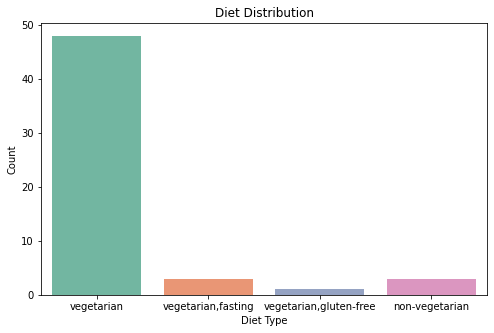

In [30]:
plt.figure(figsize=(8,5))
sns.countplot(x='diet', data=df1, palette='Set2')
plt.title("Diet Distribution")
plt.xlabel("Diet Type")
plt.ylabel("Count")
plt.show()




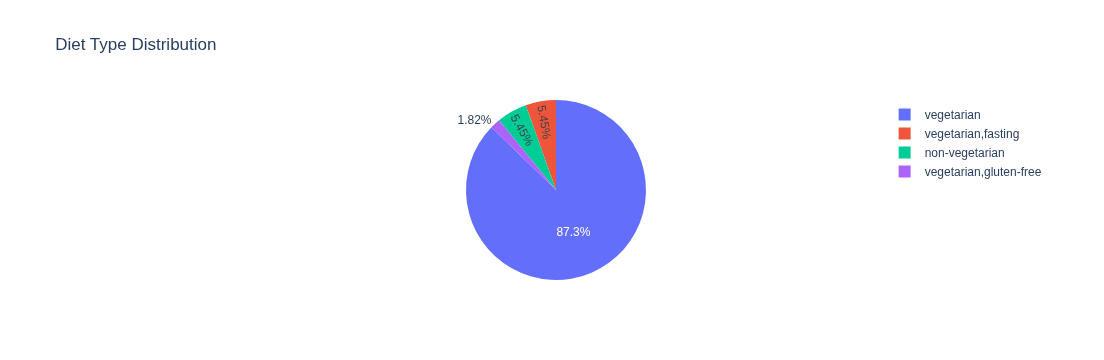

In [31]:
# Plotly Pie Chart
fig = px.pie(df1, names='diet', title='Diet Type Distribution')
fig.show()

<ipython-input-26-4fe595667889>:2: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




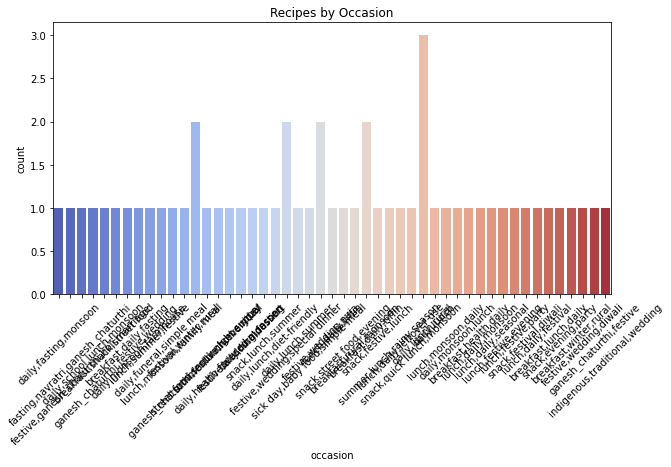

<ipython-input-26-4fe595667889>:9: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




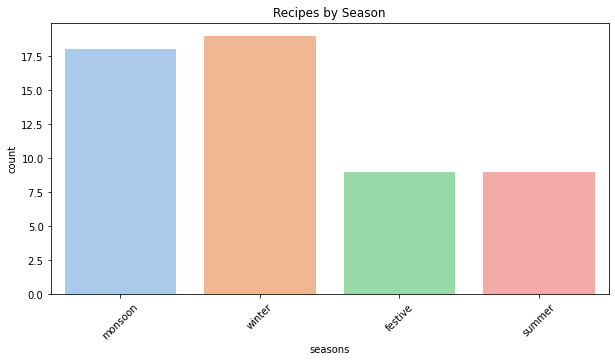

In [26]:
plt.figure(figsize=(10,5))
sns.countplot(x='occasion', data=df1, palette='coolwarm')
plt.title("Recipes by Occasion")
plt.xticks(rotation=45)
plt.show()

# Seasons analysis
plt.figure(figsize=(10,5))
sns.countplot(x='seasons', data=df1, palette='pastel')
plt.title("Recipes by Season")
plt.xticks(rotation=45)
plt.show()

<ipython-input-27-a0894e065f80>:12: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.


/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:170: UserWarning:

Glyph 2350 (\N{DEVANAGARI LETTER MA}) missing from font(s) DejaVu Sans.

/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:170: UserWarning:

Matplotlib currently does not support Devanagari natively.

/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:170: UserWarning:

Glyph 2368 (\N{DEVANAGARI VOWEL SIGN II}) missing from font(s) DejaVu Sans.

/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:170: UserWarning:

Glyph 2336 (\N{DEVANAGARI LETTER TTHA}) missing from font(s) DejaVu Sans.

/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:170: UserWarning:

Glyph 2340 (\N{DEVANAGARI LETTER TA}) missing from font(s) DejaV

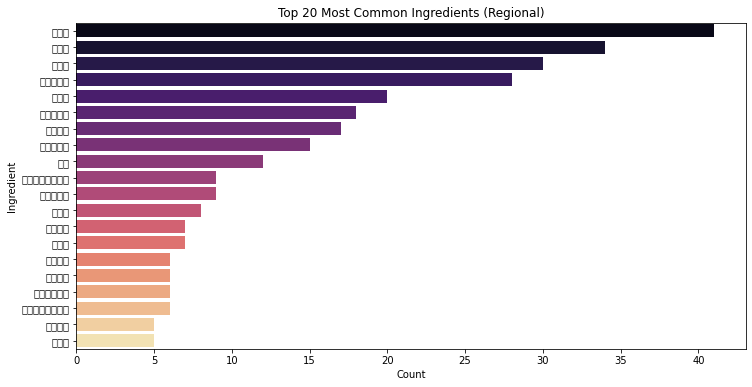

In [27]:
from collections import Counter

# Split all regional ingredients
all_ingredients = df1['ingredients_regional'].dropna().str.split(',').sum()
ingredient_counts = Counter(all_ingredients)

# Top 20 ingredients
top_ingredients = ingredient_counts.most_common(20)
ingredients, counts = zip(*top_ingredients)

plt.figure(figsize=(12,6))
sns.barplot(x=list(counts), y=list(ingredients), palette='magma')
plt.title("Top 20 Most Common Ingredients (Regional)")
plt.xlabel("Count")
plt.ylabel("Ingredient")
plt.show()

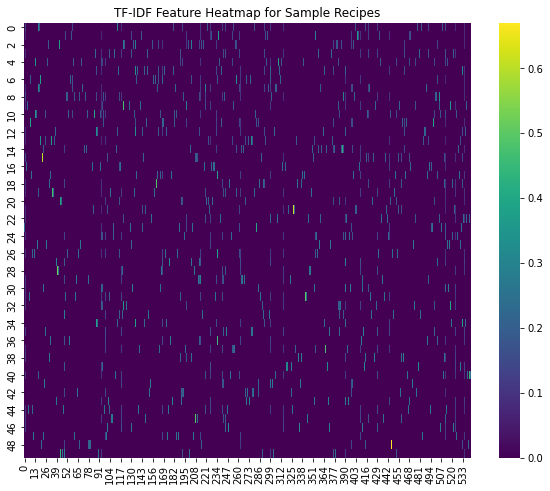

In [29]:
# Sample 50 recipes
sample_matrix = model_matrix[:50].toarray()
plt.figure(figsize=(10,8))
sns.heatmap(sample_matrix, cmap='viridis')
plt.title("TF-IDF Feature Heatmap for Sample Recipes")
plt.show()